<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Background" data-toc-modified-id="Background-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Preprocessing</a></span></li><li><span><a href="#Training-Model-and-Forecasting" data-toc-modified-id="Training-Model-and-Forecasting-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training Model and Forecasting</a></span><ul class="toc-item"><li><span><a href="#Naive-Forecasting-Model" data-toc-modified-id="Naive-Forecasting-Model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Naive Forecasting Model</a></span></li><li><span><a href="#Moving-Average-Model" data-toc-modified-id="Moving-Average-Model-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Moving Average Model</a></span></li><li><span><a href="#ARIMA-Model" data-toc-modified-id="ARIMA-Model-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>ARIMA Model</a></span></li><li><span><a href="#Simple-DNN-Model" data-toc-modified-id="Simple-DNN-Model-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Simple DNN Model</a></span></li><li><span><a href="#RNN-Model" data-toc-modified-id="RNN-Model-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>RNN Model</a></span></li></ul></li></ul></div>

# Background

`Sunspots` are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection. `Sunspot activity cycles` are about every eleven years, with some variation in length. Over the solar cycle, sunspot populations rise quickly and then fall more slowly.

The 11-year sunspot cycle is actually half of a longer, 22-year cycle of solar activity. Each time the sunspot count rises and falls, the magnetic field of the Sun associated with sunspots reverses polarity; the orientation of magnetic fields in the Sun's northern and southern hemispheres switch. Thus, in terms of magnetic fields, the solar cycle is only complete (with the fields back the way they were at the start of the cycle) after two 11-year sunspot cycles. This solar cycle is, on average, about 22 years long - twice the duration of the sunspot cycle.

![Sunspot](https://www.weather.gov/images/fsd/astro/Sun_sunspot.jpg)

In this notebook, I am going to predict the monthly sunspot number based on the dataset that contains monthly mean sunspot number from 1749 to 2018. I will use multiple ways to build the prediction model, including: `Naive Forecast`, `Moving Average Forecast`, `ARIMA Forecast`, `Simple DNN Forecast`, and `RNN Forecast`.

In [ ]:
# everything can be pip install
import csv
import datetime
import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from itertools import product
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import dates as mpl_dates

In [ ]:
warnings.filterwarnings(action = 'ignore')

In [ ]:
import seaborn as sns

# Data Preprocessing

In [ ]:
# define a function to plot time series data
def plot_series(time, series, col = 'dodgerblue', lab = 'original', format="-", start=0, end=None):
    # plt.style.use('seaborn')
    plt.plot(time[start:end], series[start:end], format, color = col, label = lab)
    plt.xlabel("Time")
    plt.ylabel("Series")
    # display the grid
    plt.grid(True)
    # got current figure, then autoformat date
    plt.gcf().autofmt_xdate()
    # format datetime
    date_formate = mpl_dates.DateFormatter('%b/%d/%Y')
    # set the format to out x-axis, gca is the get current axis
    plt.gca().xaxis.set_major_formatter(date_formate)
    plt.tight_layout()
    plt.legend(loc = 'best')

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/HarpyTech/DSAI-MTech/refs/heads/main/TSF/Sun_Spots/train.csv')

df.head()
# check for missing value using df.isnull(), there isn't any NaN value in this dataframe

,Month,Avg_sunspot_count
0,01-01-1749,97
1,02-01-1749,104
2,03-01-1749,117
3,04-01-1749,93
4,05-01-1749,142


In [ ]:
timeseries = df
timeseries['Month'] = pd.to_datetime(df['Month'])
timeseries = df.set_index(df['Month'])
del timeseries['Month']
timeseries.head()

,Avg_sunspot_count
Month,
1749-01-01,97
1749-02-01,104
1749-03-01,117
1749-04-01,93
1749-05-01,142


<Axes: xlabel='Month'>

<Figure size 1000x600 with 0 Axes>

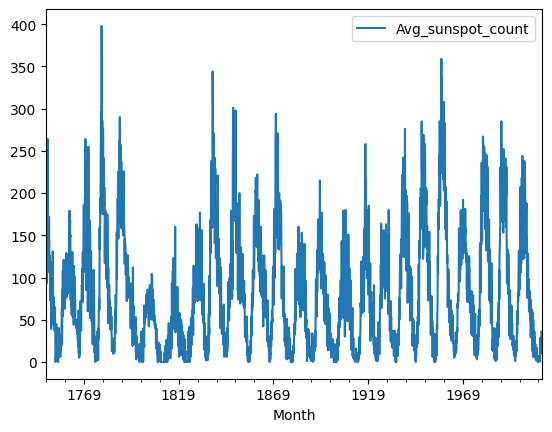

In [ ]:
time_step = []
sunspots = []
for time, value in zip(df['Month'],df['Avg_sunspot_count']):
    time_step.append(time)
    sunspots.append(float(value))

# plot our data
plt.figure(figsize=(10, 6))

timeseries.plot.line()
#plot_series(time_step, sunspots)

Firstly, it's a univariate time series problem, as a result of only one response variable. Also, according to commen patterns of time series:
- Trend: Upward? downward? There isn't any obvious trend.
- White nosie: Mean 0? constant variance? 0 correlation between lags? It's
- Auto correlation: Deeper analysis when using the ARIMA model.  
- Seasonality: It's pretty obvious, as the background part introduced, 11 years is the period of sunspots' seasonality. After zoom into the figure, 11 years will be more clear.

[What is autocorrelation and partial autocorrelation?](https://www.youtube.com/watch?v=ZjaBn93YPWo)

[ACF vs. PACF](https://www.youtube.com/watch?v=DeORzP0go5I)

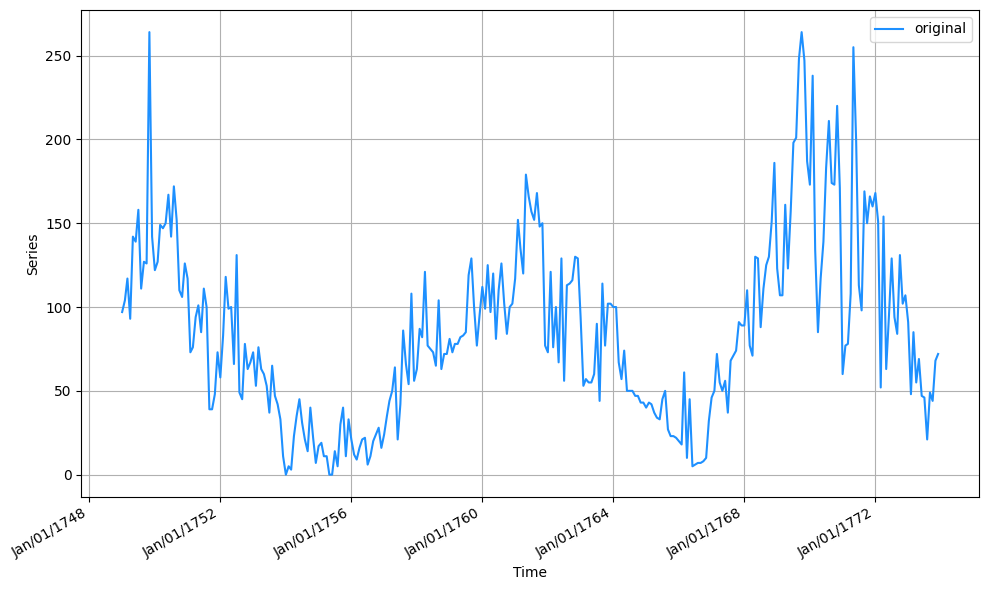

In [ ]:
# zoom into the plot, the seasonality is roughly 11 years
plt.figure(figsize=(10, 6))
plot_series(time_step, sunspots, start=0, end=300)

In [ ]:
# split data into validation and training datasets
split_time = int(len(time_step)*0.8)
time_train = time_step[:split_time]
x_train = sunspots[:split_time]
time_valid = time_step[split_time:]
x_valid = sunspots[split_time:]

In [ ]:
# becasue data is from time_step and sunspots, here our data are in list type
type(x_train)

list

In [ ]:
# I will also split it this way, and now train and vaild dataset are daraframe
split_time = int(len(time_step)*0.8)
train = timeseries[:split_time]
valid = timeseries[split_time:]

In [ ]:
train.head()

,Avg_sunspot_count
Month,
1749-01-01,97
1749-02-01,104
1749-03-01,117
1749-04-01,93
1749-05-01,142


In [ ]:
train.index

DatetimeIndex(['1749-01-01', '1749-02-01', '1749-03-01', '1749-04-01',
               '1749-05-01', '1749-06-01', '1749-07-01', '1749-08-01',
               '1749-09-01', '1749-10-01',
               ...
               '1957-10-01', '1957-11-01', '1957-12-01', '1958-01-01',
               '1958-02-01', '1958-03-01', '1958-04-01', '1958-05-01',
               '1958-06-01', '1958-07-01'],
              dtype='datetime64[ns]', name='Month', length=2515, freq=None)

# Training Model and Forecasting

## Naive Forecasting Model

Firstly, I am going to build a `naive forecasting model`, which is a baseline of forecasting models. The last period's actuals are used as this period's forecast, without adjusting them or attempting to establish causal factors. `Naive forecasting model` is used only for comparison with the forecasts generated by the better (sophisticated) techniques.

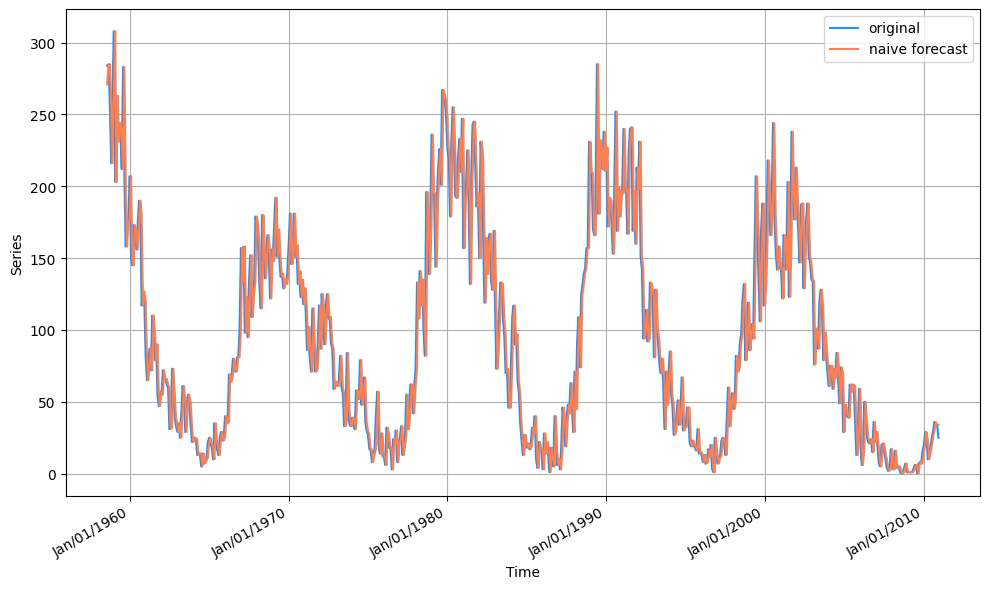

In [ ]:
naive_forecast = sunspots[split_time - 1:-1]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast, col = 'coral', lab = 'naive forecast')

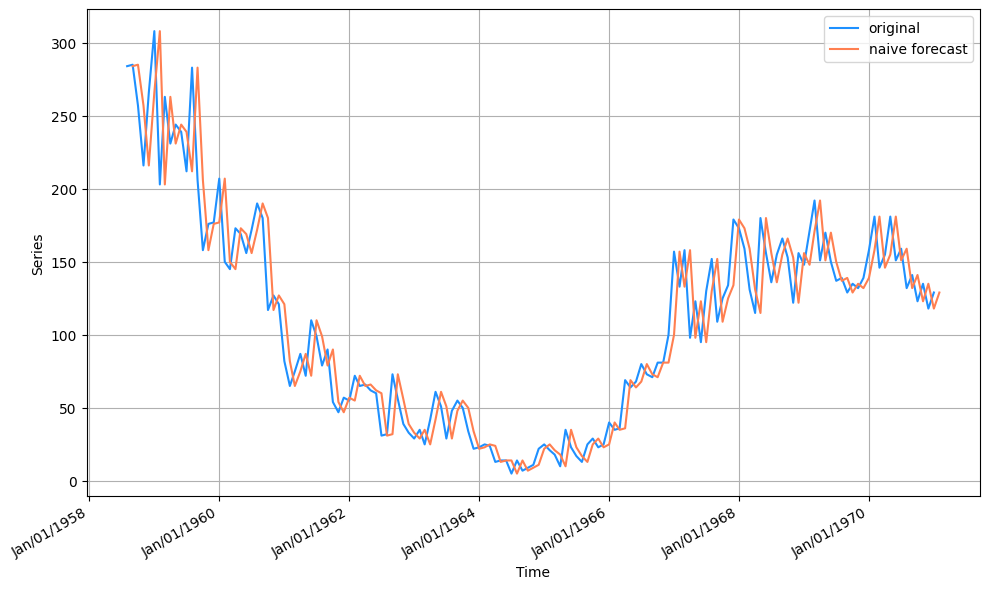

In [ ]:
# zoom into to figure to avoid overlap
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151, col = 'coral', lab = 'naive forecast')
# the orange data is just one step after the blue data

Metrix including MSE(mean square errors), RMSE(root means squared error), MAPE(mean ratio between the absolute error and the absolute value ), and MAE(mean absolute error). In this case, I will use MAE, which does not penalize large errors as much as the MSE does.

In [ ]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(x_valid, naive_forecast))

19.220985691573926


Therefore, 18.45 is the baseline.

## Moving Average Model

In [ ]:
# Firstly, define a function for moving average forecast
# window size means forecasts the means for the last few values
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

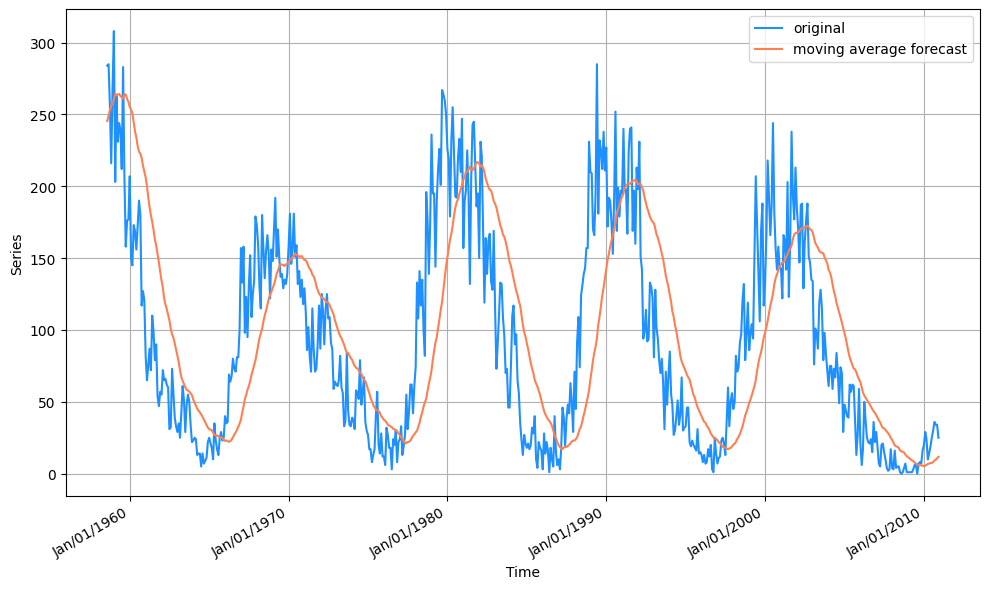

In [ ]:
# turn data into numpy array
series = np.array(sunspots)
time = np.array(time_step)
# here, the windex size is set to be 30
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg, col = 'coral', lab = 'moving average forecast')

In [ ]:
print(mean_absolute_error(x_valid, moving_avg))

42.26216216216216


According to the new MAE, the model is worse than naive forecast! The moving average does not anticipate trend or seasonality. So let's try to remove them by using differencing. Since the seasonality period is 11 years, we will subtract the value at time t – 132 from the value at time t.

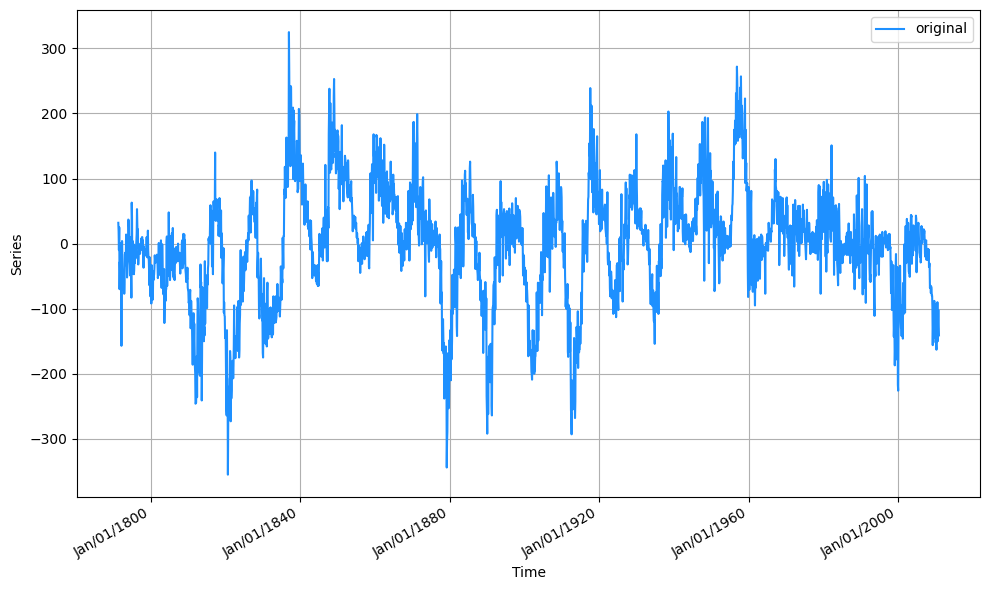

In [ ]:
# difference between time t and 132 timesteps before that
# after finding to optimal parameter, seasonality is set to be 507
seasonality = 507
diff_series = (series[seasonality:] - series[:-seasonality])
diff_time = time[seasonality:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

The seasonality is gone to a certain extent. Now I can use the moving average again.

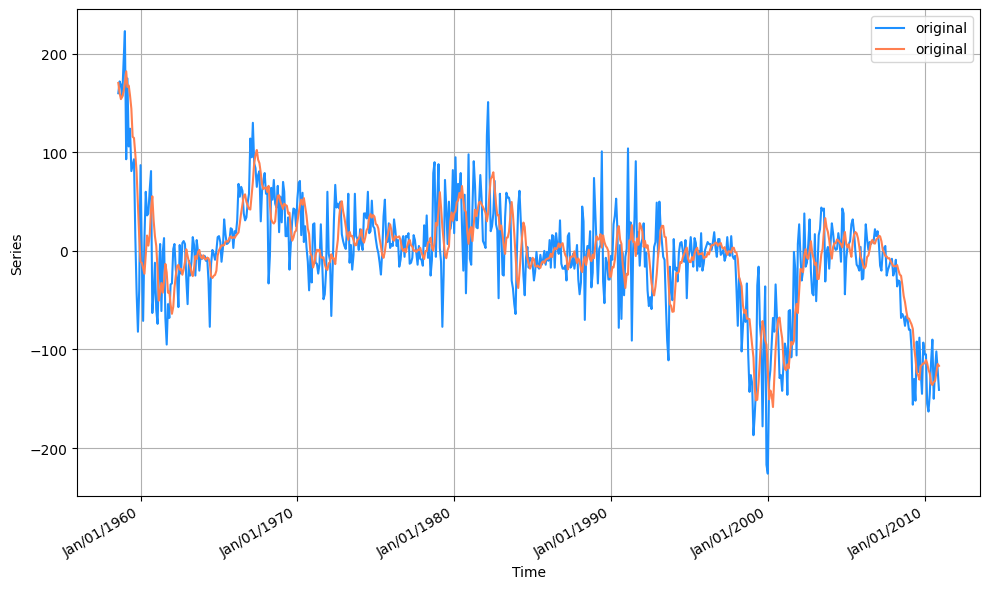

In [ ]:
# try window size 20
# after finding to optimal parameter, window size is set to be 5
diff_moving_avg = moving_average_forecast(diff_series, 5)[split_time - seasonality - 5:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - seasonality:])
plot_series(time_valid, diff_moving_avg, col = 'coral')
plt.show()

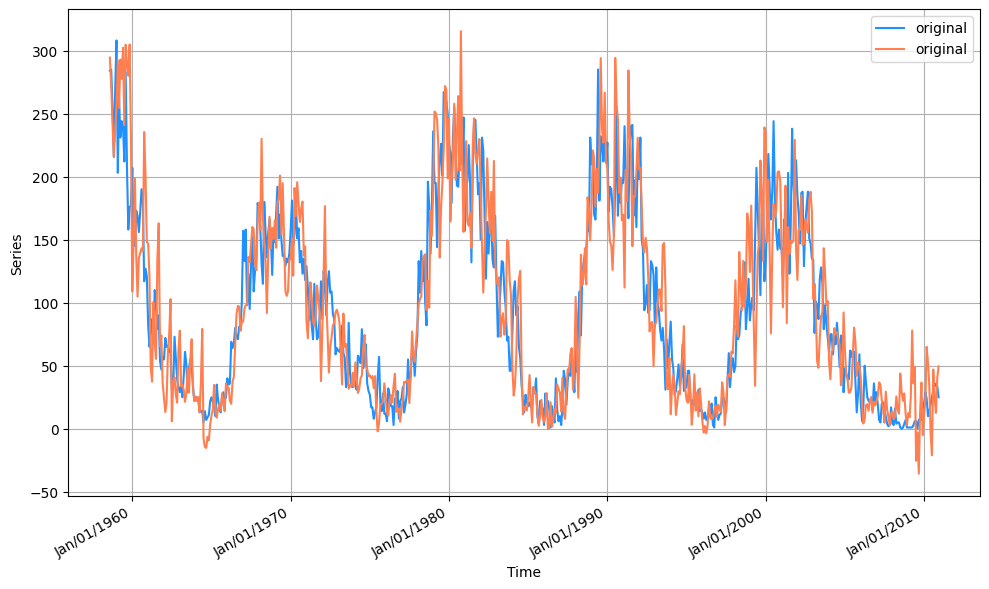

In [ ]:
# adding back the past value
diff_moving_avg_plus_past = series[split_time - seasonality:-seasonality] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past, col = 'coral')
plt.show()

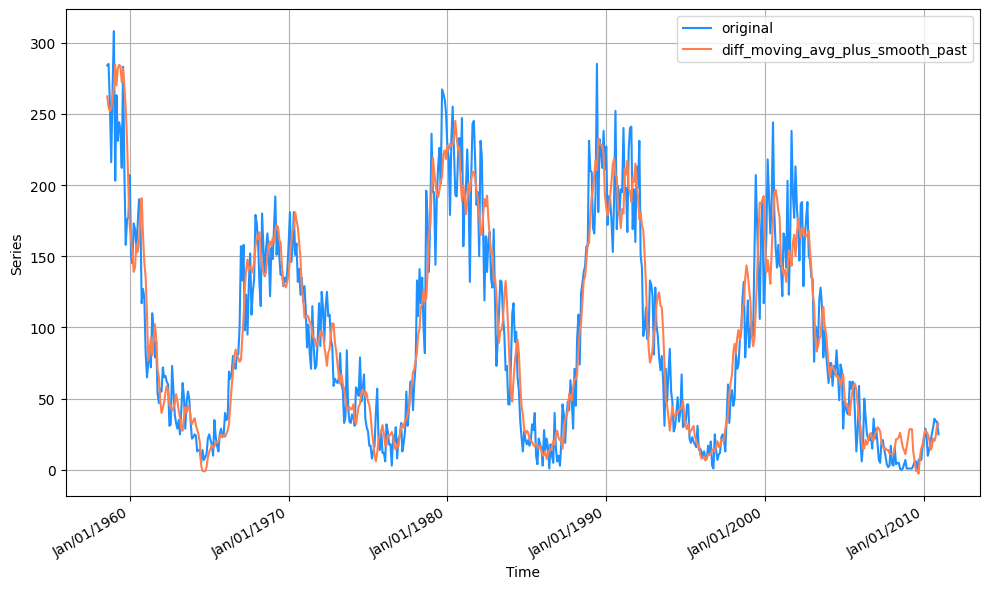

In [ ]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - seasonality-5:-seasonality+5], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past, col = 'coral', lab = 'diff_moving_avg_plus_smooth_past')
plt.show()

In [ ]:
print(mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past))

19.32368839427663


It looks like this model is pretty bad, beacuse it's under our baseline. Maybe there is some problem with hyper-paramater, like window_size and seasonality. I would like to iterate over different hyper-parameter and find the optimal solution.

In [ ]:
seasonpara = []
mae = []
window = []
for window_size in range(1,10):
    for seasonality in range(500, 600):
        diff_series = (series[seasonality:] - series[:-seasonality])
        diff_time = time[seasonality:]
        diff_moving_avg = moving_average_forecast(diff_series, window_size)[split_time - seasonality - window_size:]
        diff_moving_avg_plus_past = series[split_time - seasonality:-seasonality] + diff_moving_avg
        diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - seasonality-5:-seasonality+5], 10) + diff_moving_avg
        seasonpara.append(seasonality)
        mae.append(mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past))
        window.append(window_size)

In [ ]:
for i in mae:
    if i == min(mae):
        print(f'The optimal seaonality is: {seasonpara[mae.index(i)]}')
        print(f'The optimal window size is: {window[mae.index(i)]}')
        print(f'The optimal MAE is: {min(mae)}')

The optimal seaonality is: 507
The optimal window size is: 5
The optimal MAE is: 19.32368839427663


## ARIMA Model

__What is ARIMA?__

ARIMA, short for `'Auto Regressive Integrated Moving Average'` is actually a class of models that explains a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values. Any 'non-seasonal' time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models. ARIMA require `stationary time series data`, so the first step is `stationary`.

__What is stationary?__

The mean/variance of time series data doesn't change over time; the autocorrelation coefficient only related with time lags.

__Why we need stationary?__

Because, term`'Auto Regressive'` in ARIMA means it is a `linear regression model` that uses its own lags as predictors. `Linear regression models`, as you know, work best when the predictors are not correlated and are independent of each other.

__3 terms of ARIMA__

An ARIMA model is characterized by 3 terms: p, d, q
- p: the order of the AR term. It refers to the number of lags of Y to be used as predictors.
- q: the order of the MA term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.
- d: the number of differencing required to make the time series stationary. The most common approach is to difference it. That is, subtract the previous value from the current value. Sometimes, depending on the complexity of the series, more than one differencing may be needed. The value of d, therefore, is the minimum number of differencing needed to make the series stationary. And if the time series is already stationary, then d = 0.

__AR & I & MA__

AR means Auto Regressive, MA means Moving Average, it refers to Integrated/difference.

A pure Auto Regressive (AR only) model is one where $Y_t$ depends only on its own lags. That is, $Y_t$ is a function of the 'lags of $Y_t$'. $Y_{t-1}$ is the lag1 of the series, $\beta_1$ is the coefficient of lag1 that the model estimates and $\alpha$ is the intercept term, also estimated by the model.

$$ Y_t = \alpha + \beta_1Y_{t-1} + \beta_2Y_{t-2} + .. + \beta_pY_{t-p} + \epsilon_1  $$

Likewise a pure Moving Average (MA only) model is one where $Y_t$ depends only on the lagged forecast errors.

$$ Y_t = \alpha +\epsilon_t + \phi_1\epsilon_{t-1} + \phi_2\epsilon_{t-2} .. + \phi_q\epsilon_{t-q}  $$

Where the error terms are the errors of the autoregressive models of the respective lags. The errors $\epsilon_t$ and $\epsilon_{t-1}$ are the errors from the following equations :

$$ Y_t = \beta_1Y_{t-1} + \beta_2Y_{t-2} + .. + \beta_0Y_0 + \epsilon_t  $$

$$ Y_{t-1} = \beta_1Y_{t-2} + \beta_2Y_{t-3} + .. + \beta_0Y_0 + \epsilon_{t-1}  $$

An ARIMA model is one where the time series was differenced at least once to make it stationary and you combine the AR and the MA terms. So the equation becomes:

$$ Y_t = \alpha + \beta_1Y_{t-1} + \beta_2Y_{t-2} + .. + \beta_pY_{t-p}\epsilon_t + \phi_1\epsilon_{t-1} + \phi_2\epsilon_{t-2} .. + \phi_q\epsilon_{t-q} $$

Predicted $Y_t$ = Constant + Linear combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags)

In [ ]:
timeseries.head()

,Avg_sunspot_count
Month,
1749-01-01,97
1749-02-01,104
1749-03-01,117
1749-04-01,93
1749-05-01,142


In [ ]:
def plot_rol(timeseriesdata, size):
    plt.figure(figsize=(15, 7))
    # plt.style.use('seaborn')
    # rolling statistics
    rol_mean = timeseriesdata.rolling(window=size).mean()
    rol_std = timeseriesdata.rolling(window=size).std()
    plt.plot(timeseriesdata, color='dodgerblue', label='Original')
    plt.plot(rol_mean, color='red', label='Rolling Mean')
    plt.plot(rol_std, color='green', label='Rolling standard deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    # let the axis off for convenience
    plt.axis('off')
    plt.show()

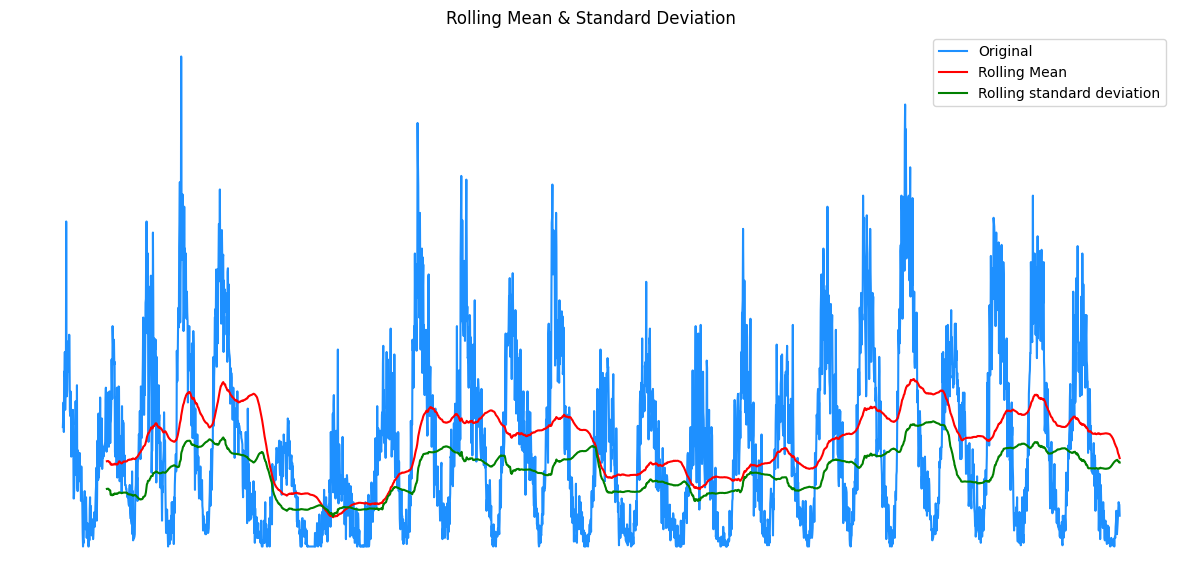

In [ ]:
plot_rol(timeseries, 132)

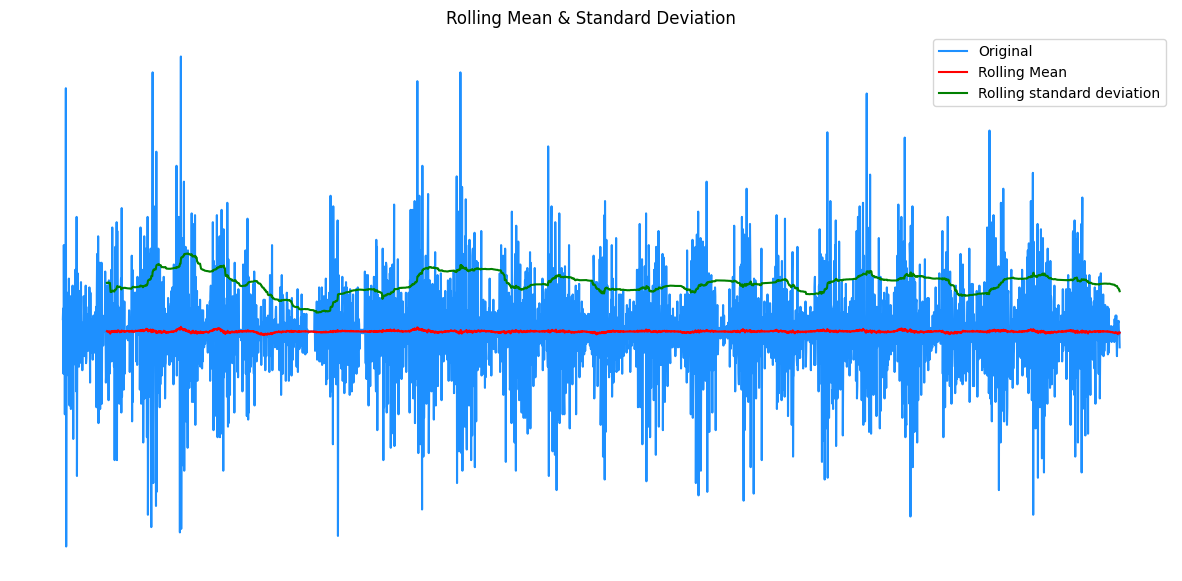

In [ ]:
plot_rol(timeseries.diff(1), 132)

Firstly, check if the series is stationary using the `Augmented Dickey Fuller test` (adfuller()), from the statsmodels package. Differencing is needed only if the series is non-stationary. Else, no differencing is needed, that is, d=0. The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

In [ ]:
# define a function for adfuller test
def teststationarity(ts):
    print('result of dickey-fuller test:')
    dftest = adfuller(ts['Avg_sunspot_count'], autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

In [ ]:
teststationarity(timeseries)

result of dickey-fuller test:


,0
Test Statistic,-1.039031e+01
p-value,2.029077e-18
#Lags Used,2.800000e+01
Number of Observations Used,3.115000e+03
Critical Value (1%),-3.432451e+00
Critical Value (5%),-2.862468e+00
Critical Value (10%),-2.567264e+00


With a pretty small p-value(or critical value < test statistic), reject the null hypothesis. Data is already stationary. d = 0.

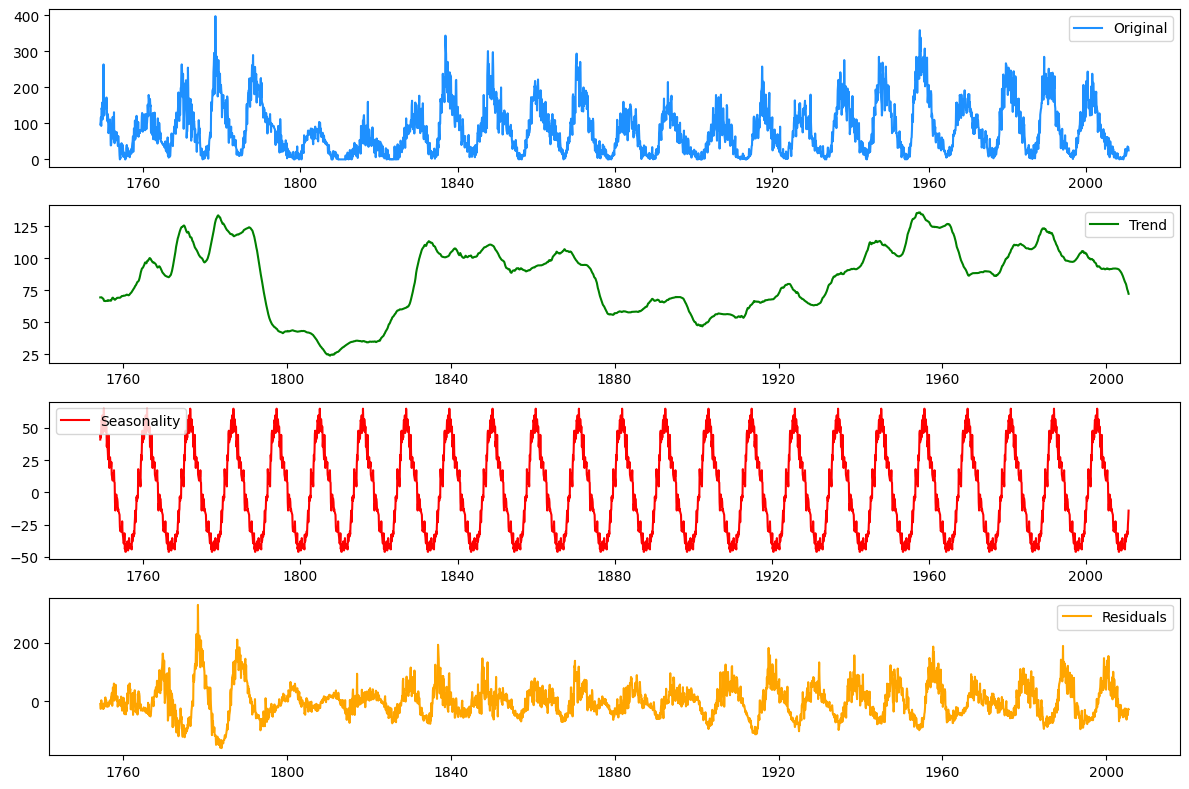

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(timeseries.dropna(), period = 132)

# get the trend, seasonality and noise
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(timeseries, label='Original', color="dodgerblue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="green")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="red")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="orange")
plt.legend(loc='best')
plt.tight_layout()

The next step is to identify if the model needs any AR terms. You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot. Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.

$$Y_t = \alpha_0 + \alpha_1Y_{t-1} + \alpha_2Y_{t-2} + \alpha_3Y_{t-3}$$

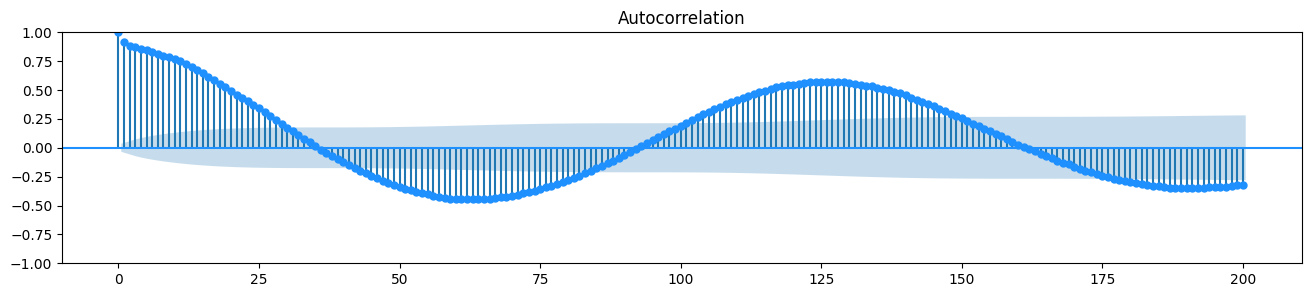

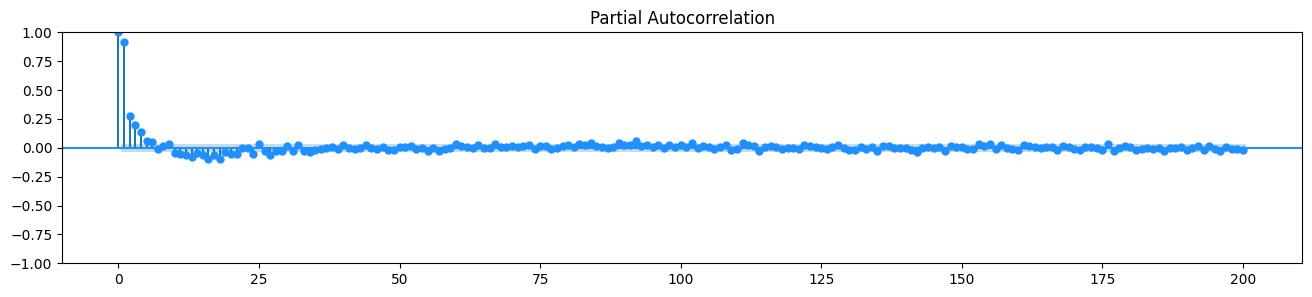

In [ ]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(timeseries,ax=ax, lags = 200, color="dodgerblue");

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(timeseries,ax=ax, lags = 200, color="dodgerblue")
plt.show()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

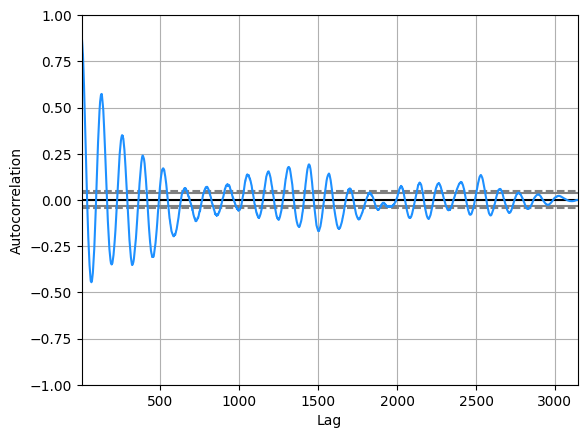

In [ ]:
autocorrelation_plot(timeseries, color='dodgerblue')

Stationary time series always have short-term correlation, so the autocorrelation coefficient will quickly coverage to 0.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

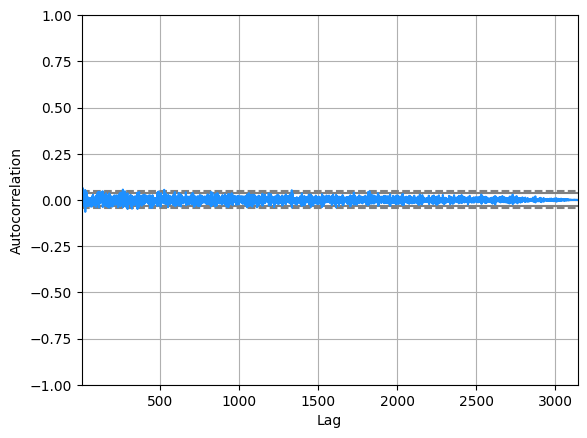

In [ ]:
# the first value is NaN when use a diff
autocorrelation_plot(timeseries.diff(1)[1:], color='dodgerblue')
# in this case, the model is overfitting

With a seaonality of 11 years (132 months), it turn out to be quiet challenging when iterating to find optimal SARIMA parameters. I spent a lot of time working on this problem, but still can not solve it. Therefore, I temporarily resample the data using 'A', which means each time step is a year now. The seaonality is 11 currently. That will save a lot of iterating time.

In [ ]:
atrain = train.resample('A').sum()
avalid = valid.resample('A').sum()
avalid.head()

,Avg_sunspot_count
Month,
1958-12-31,1308
1959-12-31,2700
1960-12-31,1907
1961-12-31,917
1962-12-31,644


In [ ]:
# Initial approximation of parameters
Qs = range(0, 3)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(atrain['Avg_sunspot_count'], order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 11)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [ ]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                    Avg_sunspot_count   No. Observations:                  210
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 11)   Log Likelihood               -1438.463
Date:                              Sat, 08 Feb 2025   AIC                           2890.926
Time:                                      17:25:30   BIC                           2913.944
Sample:                                  12-31-1749   HQIC                          2900.243
                                       - 12-31-1958                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4335      0.059     24.149      0.000       1.317       1.550
ar.L2         -0.8100      0.055    -14.633      0.000      -0.919      -0.702
ma.L1         -1.2698      0.100    -12.705      0.000      -1.466      -1.074
ma.L2          0.3799      0.099      3.824      0.000       0.185       0.575
ar.S.L11       0.1459      0.099      1.469      0.142      -0.049       0.341
ma.S.L11      -0.9929      1.273     -0.780      0.435      -3.487       1.501
sigma2      1.041e+05   1.27e+05      0.818      0.413   -1.45e+05    3.54e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):                77.76
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                             0.02
Prob(H) (two-sided):                  0.42   Kurtosis:                         6.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

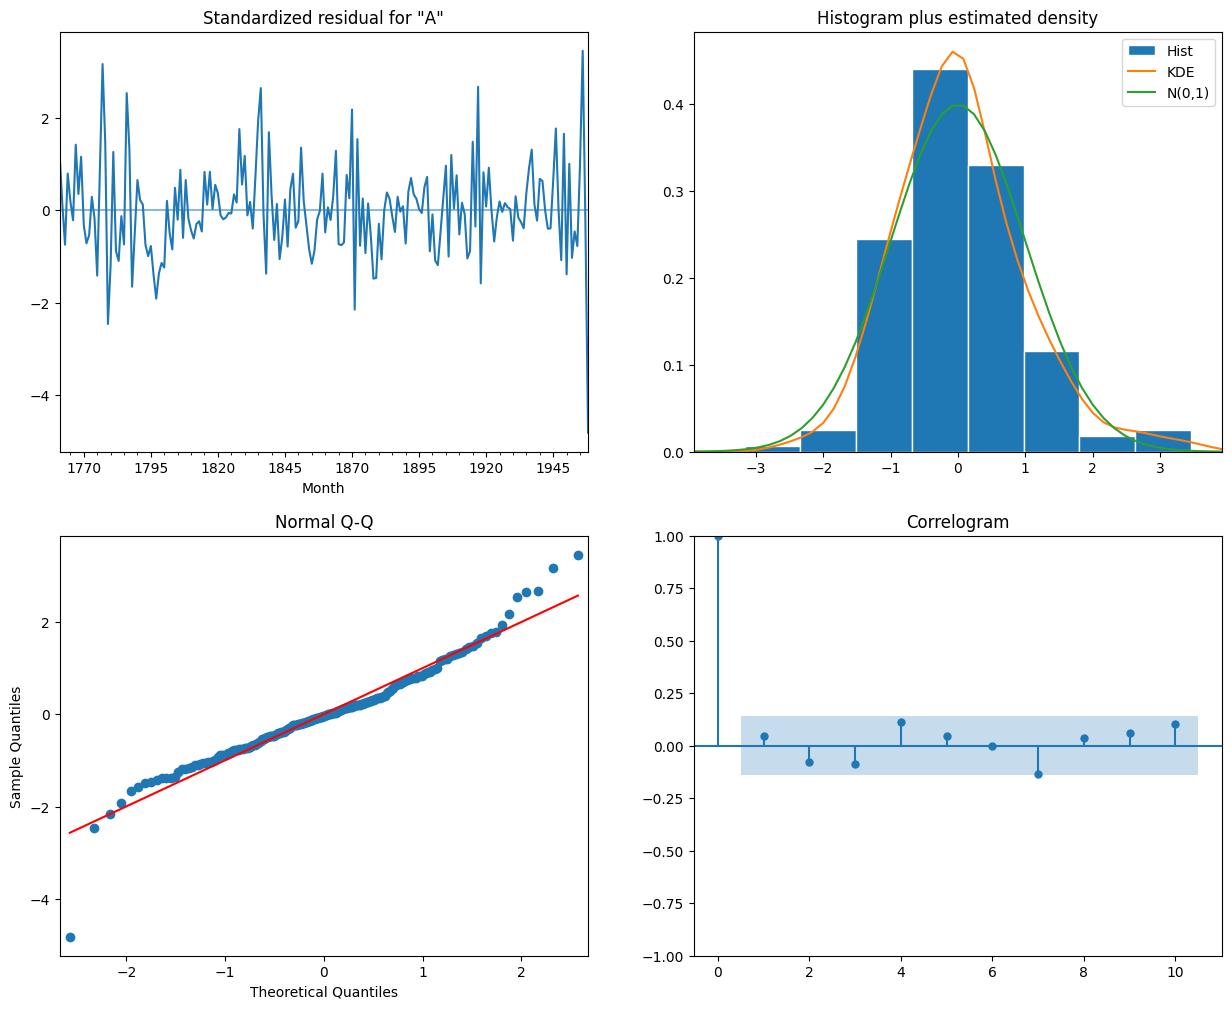

In [ ]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

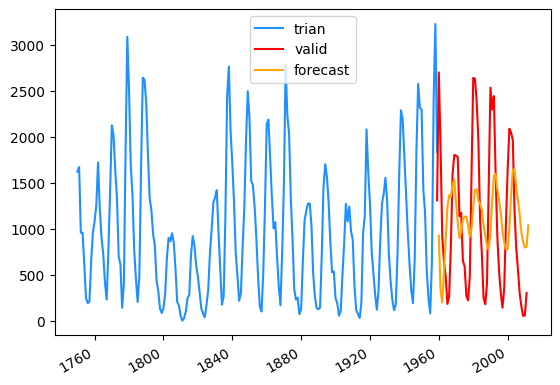

In [ ]:
plt.plot(atrain,color = 'dodgerblue',label = 'trian')
plt.plot(avalid, color = 'r',label = 'valid')
best_model.forecast(len(avalid)).plot(color = 'orange',label = 'forecast')
plt.legend(loc = 'best')
plt.show()

In [ ]:
best_param, best_aic

((2, 2, 1, 1), 2890.9262194391113)

In [ ]:

from sklearn.metrics import mean_squared_error
import math

# Assuming 'best_model' and 'avalid' are defined as in your provided code.
predictions = best_model.forecast(len(avalid))
rmse = math.sqrt(mean_squared_error(avalid['Avg_sunspot_count'], predictions))
print(f"RMSE: {rmse}")

len(avalid)

RMSE: 765.481716702816


53

## Simple DNN Model

First of all, as with any other ML problem, we have to divide our data into features and labels. In this case our feature is effectively a number of values in the series, with our label being the next value. We'll call that number of values that will treat as our feature, the window size, where we're taking a window of the data and training an ML model to predict the next value. So for example, if we take our time series data, say, 30 days at a time, we'll use 30 values as the feature and the next value is the label. Then over time, we'll train a neural network to match the 30 features to the single label.

In [ ]:
# define some hyper-parameter
window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

# turn a series into a dataset which we can train on
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # create a dataset from series
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # slice the data up into appropriate windows
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    # flattened into chunks in the size of our window size + 1
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    # batched into the selected batch size and returned
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

Once it's flattened, it's easy to shuffle it. You call a shuffle and you pass it the shuffle buffer. Using a shuffle buffer speeds things up a bit. So for example, if you have 100,000 items in your dataset, but you set the buffer to a thousand. It will just fill the buffer with the first thousand elements, pick one of them at random. And then it will replace that with the 1,000 and first element before randomly picking again, and so on. This way with super large datasets, the random element choosing can choose from a smaller number which effectively speeds things up.

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# three layer of 20,10 and 1 neurons, input shape is the size of window
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9))
# ignore the epoch by epoch output by setting verbose = 0
history = model.fit(dataset,epochs=200,verbose=0)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 20)                  │           1,220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,884 (11.27 KB)

 Trainable params: 1,441 (5.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,443 (5.64 KB)

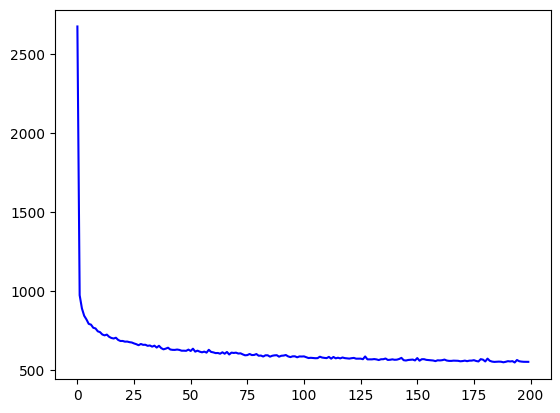

In [ ]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━

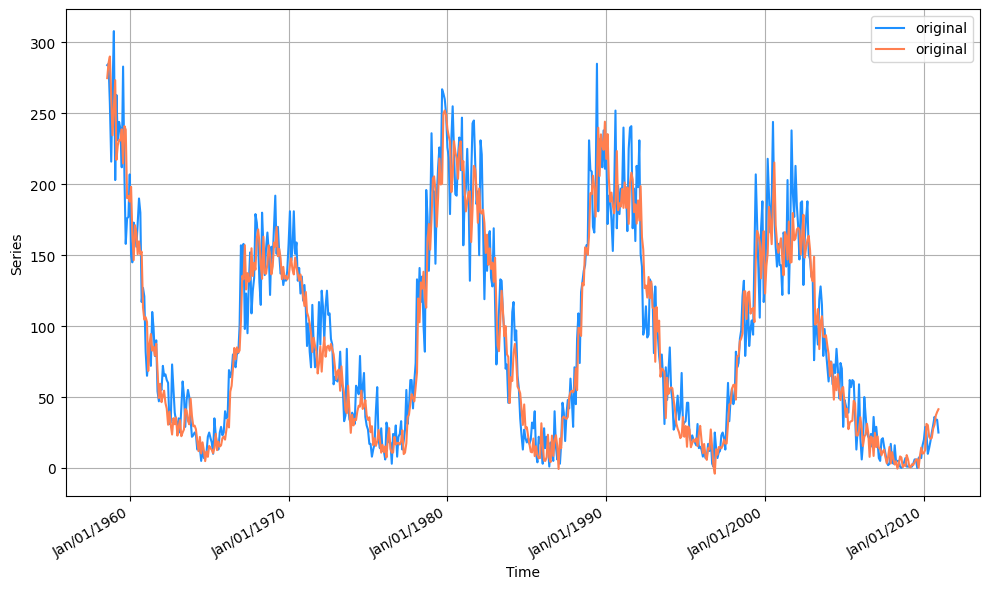

In [ ]:
series = np.array(sunspots)
time = np.array(time_step)
forecast=[]

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results, col = 'coral')

In [ ]:
mean_absolute_error(x_valid, results).numpy()

## RNN Model

A `Recurrent Neural Network`, or RNN is a neural network that contains recurrent layers. These are designed to sequentially processes sequence of inputs. RNNs are pretty flexible, able to process all kinds of sequences. The full input shape when using RNNs is three-dimensional. The first dimension will be the `batch size`, the second will be the `timestamps`, and the third is the `dimensionality of the inputs at each time step`. In this case, it's a univariate time series, this value will be one.

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  # Sequence to Sequence for LSTM
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# twick the learning rate, use the optimal learning rate instead of one
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule],verbose = 0)

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])
# y is the loss and x is the learning rate
# set the lr to be the optimal, where the loss is this minimum

In [ ]:
# this clears any internal variables, which makes it easy for us to experiment without models impacting later versions of themselves.
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500,verbose=0)

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
print(rnn_forecast)